#Yolov5 + Weighted_Box_fusion Ensemble

1) 4개의 Yolo model Ensemble:
  - 384*384 Yolov5 - Large
  - 512*512 Yolov5 - Large
  - 512*512 Yolov5 - small
  - 576*576 Yolov5 - small

  - Image Feature에 대해 다른 차원에 대해 접근하고 이에 대해 Ensemble 진행

  - Yolov5-small: Colab GPU / Yolov5-Large: Kaggle GPU에서 각각 학습
 
  - Train/Test를 8:2로 분리하여 Validation 진행

  - Hyperparameter: learning_rate=0.01, momentum=0.937(Optimizer='SGD'), weight_decay=0.0005, iou_threshold=0.2, batch_size=64, epoch=30

  - 원래 이미지 사이즈는 576x576이나, 모델 Augmentation 및 GPU 고려 Resize 후 진행

  - Augmentation: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
  
  - Model Reference: https://github.com/ultralytics/yolov5

2) Weighted_box_fusion Ensemble:
  - bounding box를 weight 및 IoU threshold에 따라 ensemble하는 기법
  (reference: https://arxiv.org/abs/1910.13302)
  - Yolov5-large:2, Yolov5-small:1의 가중치를 두고 ensemble 진행
  - IoU Threshold: 0.53, skip threshold:0.52

++전체 Reference: https://dacon.io/competitions/official/235855/codeshare/3743?page=1&dtype=recent

++ 추후 DETReg 반영 시 Yolo + DETReg 및 함께 앙상블하고, 앙상블 코드만 추가 수정 후 쿠빅 깃헙에 제출하면 될 것 같습니다.



#Library

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
from pathlib import Path
import base64
import cv2
import matplotlib.pyplot as plt
import json 
from tqdm.notebook import tqdm 
import scipy 
from joblib import Parallel , delayed

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


#Extracting Dataset

In [ ]:
IMG_SIZE = 128
base_path = Path('/Users/jungjunlim/Desktop/Python/KUBIG_CONTEST/235855_병변 검출 AI 경진대회_data')
train_path = list((base_path /'train').glob('train*'))
test_path = list((base_path / 'test').glob('test*'))

In [ ]:
label_info = pd.read_csv((base_path /'class_id_info.csv'))
categories = {i[0]:i[1]-1 for i in label_info.to_numpy()}
label_info

,class,class_id
0,01_ulcer,1
1,02_mass,2
2,04_lymph,3
3,05_bleeding,4


In [ ]:
#Dataset 변환
def xyxy2coco(xyxy):
    x1,y1,x2,y2 =xyxy
    w,h =  x2-x1, y2-y1
    return [x1,y1,w,h] 

def xyxy2yolo(xyxy):
    
    x1,y1,x2,y2 =xyxy
    w,h =  x2-x1, y2-y1
    xc = x1 + int(np.round(w/2)) # xmin + width/2
    yc = y1 + int(np.round(h/2)) # ymin + height/2
    return [xc/IMG_SIZE,yc/IMG_SIZE,w/IMG_SIZE,h/IMG_SIZE] 

def scale_bbox(img, xyxy):
    # Get scaling factor
    scale_x = IMG_SIZE/img.shape[1]
    scale_y = IMG_SIZE/img.shape[0]
    
    x1,y1,x2,y2 =xyxy
    x1 = int(np.round(x1*scale_x, 4))
    y1 = int(np.round(y1*scale_y, 4))
    x2 = int(np.round(x2*scale_x, 4))
    y2= int(np.round(y2*scale_y, 4))

    return [x1, y1, x2, y2] # xmin, ymin, xmax, ymax

def save_image_label(json_file,mode): 
    with open(json_file,'r') as f: 
        json_file =json.load(f)

    image_id = json_file['file_name'].replace('.json','')
    
    # decode image data
    image = np.frombuffer(base64.b64decode(json_file['imageData']), np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    cv2.imwrite(str(new_image_path / (image_id + '.png')) ,image)
    
    # extract bbox
    origin_bbox = []
    if mode == 'train':
        with open(new_label_path / (image_id + '.txt'), 'w') as f:
            for i in json_file['shapes']: 
                bbox = i['points'][0] + i['points'][2]
                origin_bbox.append(bbox)
                bbox = scale_bbox(image,bbox)
                bbox = xyxy2yolo(bbox)
                
                labels = [categories[i['label']]]+bbox
                f.writelines([f'{i} ' for i in labels] + ['\n']) 
    return origin_bbox

In [ ]:
import multiprocessing as mp 

# 저장할 파일 경로
save_path = Path('/Users/jungjunlim/Desktop/Python/KUBIG_CONTEST/train_data')
new_image_path = save_path / 'images' # image폴더 
new_label_path = save_path / 'labels' # label폴더

new_image_path.mkdir(parents=True,exist_ok=True)
new_label_path.mkdir(parents=True,exist_ok=True)

# data를 생성하기 위해 mlutiprocessing 적용
tmp = Parallel(n_jobs=mp.cpu_count(),prefer="threads")(delayed(save_image_label)(str(train_json),'train') for train_json in tqdm(train_path[:]))

  0%|          | 0/62622 [00:00<?, ?it/s]

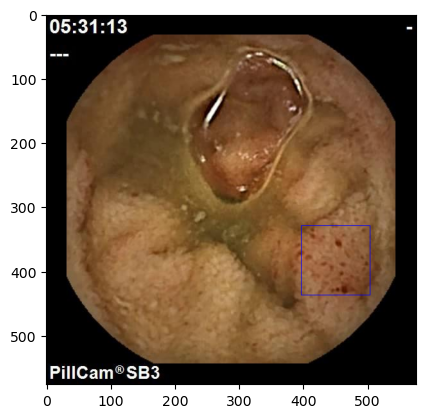

In [ ]:
n = 96
filename = train_path[n].name.replace('.json','.png')
sample = cv2.imread(f'/Users/jungjunlim/Desktop/Python/KUBIG_CONTEST/train_data/images/{filename}')[:,:,::-1].astype(np.uint8)
for i in tmp[n]: 
    i = list(map(int,i))
    sample = cv2.rectangle(sample,(i[0],i[1]),(i[2],i[3]),(0,0,255),1)
plt.imshow(sample)

In [ ]:
from sklearn.model_selection import train_test_split

save_path = Path('/content/drive/Othercomputers/내MacBookAir')
new_image_path = save_path / 'images' # image폴더 
new_label_path = save_path / 'labels'
images_path = list(new_image_path.glob('*'))[:]

train_path_list,valid_path_list = train_test_split(images_path,test_size=0.15,random_state=42)

In [ ]:
with open('/content/drive/MyDrive/dataset/KUBIGCONTEST/train_dataset.txt', 'w') as f:
    f.writelines([f'{i}\n' for i in train_path_list])
with open('/content/drive/MyDrive/dataset/KUBIGCONTEST/valid_dataset.txt', 'w') as f:
    f.writelines([f'{i}\n ' for i in valid_path_list]) 

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip ./yolov5/install requirements.txt  # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 15257, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15257 (delta 1), reused 2 (delta 0), pack-reused 15236
Receiving objects: 100% (15257/15257), 14.17 MiB | 5.00 MiB/s, done.
Resolving deltas: 100% (10457/10457), done.
ERROR: unknown command "./yolov5/install" - maybe you meant "install"


In [ ]:
! pip install -r yolov5/requirements.txt
! pip install scipy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.4.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#Wandb Login & Project

In [ ]:
!pip install -q --upgrade wandb
# Login 
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 4.5 MB/s eta 0:00:00


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import yaml

data_yaml = dict(
    train = '/content/drive/MyDrive/dataset/KUBIGCONTEST/train_dataset.txt',
    val = '/content/drive/MyDrive/dataset/KUBIGCONTEST/valid_dataset.txt',
    nc = 4,
    names = ['01_ulcer','02_mass','04_lymph','05_bleeding']
)

# Note that I am creating the file in the yolov5/data/ directory.
with open('/content/drive/MyDrive/dataset/KUBIGCONTEST/yolo_1.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

# Train !

In [ ]:
!python ./yolov5/train.py --img 576 \
                          --batch 32\
                          --epochs 30\
                          --data /content/drive/MyDrive/dataset/KUBIGCONTEST/yolo_1.yaml\
                          --weights /content/drive/MyDrive/dataset/KUBIGCONTEST/ultralyticsyolov5aweights/yolov5s.pt\
                          --project yolov5-imjjun\
                          --save-period 1\
                          --name imjjun\
                          --device cuda
                       

# Detect !

In [ ]:
!python ./yolov5/detect.py --weights /content/drive/MyDrive/dataset/KUBIGCONTEST/ultralyticsyolov5aweights/best19.pt \
                           --source /content/drive/Othercomputers/내MacBookAir/test_images \
                           --data /content/drive/MyDrive/dataset/KUBIGCONTEST/yolo_1.yaml \
                           --save-txt \
                           --save-conf \
                           --img 576 \

In [ ]:
!python ./yolov5/detect.py --weights /content/drive/MyDrive/dataset/KUBIGCONTEST/ultralyticsyolov5aweights/epoch30.pt \
                           --source /content/drive/Othercomputers/내MacBookAir/test_images \
                           --data /content/drive/MyDrive/dataset/KUBIGCONTEST/yolo_1.yaml \
                           --save-txt \
                           --save-conf \
                           --img 576 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
image 15878/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215877.jpg: 576x576 2 04_lymphs, 13.0ms
image 15879/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215878.jpg: 576x576 1 05_bleeding, 10.3ms
image 15880/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215879.jpg: 576x576 1 02_mass, 8.9ms
image 15881/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215880.jpg: 576x576 2 01_ulcers, 1 05_bleeding, 8.9ms
image 15882/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215881.jpg: 576x576 1 04_lymph, 9.5ms
image 15883/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215882.jpg: 576x576 2 04_lymphs, 9.0ms
image 15884/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215883.jpg: 576x576 2 05_bleedings, 9.2ms
image 15885/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215884.jpg: 576x576 2 01_ulcers, 9.2ms
image 158

In [ ]:
!python ./yolov5/detect.py --weights /content/drive/MyDrive/dataset/KUBIGCONTEST/ultralyticsyolov5aweights/exp1.pt \
                           --source /content/drive/Othercomputers/내MacBookAir/test_images \
                           --data /content/drive/MyDrive/dataset/KUBIGCONTEST/yolo_1.yaml \
                           --save-txt \
                           --save-conf \
                           --img 576 \
                          

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
image 15878/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215877.jpg: 576x576 1 04_lymph, 25.2ms
image 15879/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215878.jpg: 576x576 (no detections), 25.6ms
image 15880/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215879.jpg: 576x576 1 02_mass, 24.6ms
image 15881/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215880.jpg: 576x576 2 01_ulcers, 1 05_bleeding, 25.8ms
image 15882/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215881.jpg: 576x576 1 04_lymph, 24.8ms
image 15883/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215882.jpg: 576x576 2 04_lymphs, 25.3ms
image 15884/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215883.jpg: 576x576 2 05_bleedings, 25.7ms
image 15885/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215884.jpg: 576x576 2 01_ulcers, 25.4ms
im

In [ ]:
!python ./yolov5/detect.py --weights /content/drive/MyDrive/dataset/KUBIGCONTEST/ultralyticsyolov5aweights/exp2.pt \
                           --source /content/drive/Othercomputers/내MacBookAir/test_images \
                           --data /content/drive/MyDrive/dataset/KUBIGCONTEST/yolo_1.yaml \
                           --save-txt \
                           --save-conf \
                           --img 576 \
                           

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
image 15878/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215877.jpg: 576x576 1 04_lymph, 25.2ms
image 15879/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215878.jpg: 576x576 1 05_bleeding, 24.8ms
image 15880/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215879.jpg: 576x576 1 02_mass, 25.0ms
image 15881/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215880.jpg: 576x576 2 01_ulcers, 2 05_bleedings, 24.5ms
image 15882/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215881.jpg: 576x576 1 04_lymph, 25.2ms
image 15883/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215882.jpg: 576x576 2 04_lymphs, 25.3ms
image 15884/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215883.jpg: 576x576 1 05_bleeding, 24.8ms
image 15885/20874 /content/drive/Othercomputers/내MacBookAir/test_images/test_215884.jpg: 576x576 2 01_ulcers, 24.8ms
imag

#Submission file

In [ ]:
def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.copy()
    y[0] = x[0] - x[2] / 2  # top left x
    y[1] = x[1] - x[3] / 2  # top left y
    y[2] = x[0] + x[2] / 2  # bottom right x
    y[3] = x[1] + x[3] / 2  # bottom right y
    return y

total_list = []
results = {
    'file_name':[], 'class_id':[], 'confidence':[], 'point1_x':[], 'point1_y':[],
    'point2_x':[], 'point2_y':[], 'point3_x':[], 'point3_y':[], 'point4_x':[], 'point4_y':[]
}

result_path = Path('./yolov5/runs/detect/exp5')
result_img = list(result_path.glob('*.jpg'))
result_label = list(result_path.glob('labels/*.txt'))

for i in result_label:

    with open(str(i),'r') as f:

        file_name = i.name.replace('.txt','.json')
        img_name = file_name.replace('.json','.jpg')
        ow,oh,_ = cv2.imread(str(result_path / img_name))[:,:,::-1].shape
        for line in f.readlines():
            corrdi = line[:-1].split(' ')
            label,xc,yc,w,h,score = corrdi
            xc,yc,w,h,score = list(map(float,[xc,yc,w,h,score]))
            xc,w = np.array([xc,w]) * ow
            yc,h = np.array([yc,h]) * oh

            refine_cordi = xywh2xyxy([xc,yc,w,h])
            refine_cordi = np.array(refine_cordi).astype(int)
            x_min,y_min,x_max,y_max = refine_cordi

            results['file_name'].append(file_name)
            results['class_id'].append(label)
            results['confidence'].append(score)
            results['point1_x'].append(x_min)
            results['point1_y'].append(y_min)
            results['point2_x'].append(x_max)
            results['point2_y'].append(y_min)
            results['point3_x'].append(x_max)
            results['point3_y'].append(y_max)
            results['point4_x'].append(x_min)
            results['point4_y'].append(y_max)

In [ ]:
df = pd.DataFrame(results)
df['class_id'] = df['class_id'].apply(lambda x:int(x)+1)
df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,test_208817.json,1,0.531754,32,250,126,250,126,391,32,391
1,test_220376.json,4,0.352608,195,221,237,221,237,262,195,262
2,test_220376.json,4,0.663741,51,413,106,413,106,483,51,483
3,test_203504.json,1,0.744652,389,292,518,292,518,390,389,390
4,test_218917.json,1,0.414194,439,81,531,81,531,163,439,163
...,...,...,...,...,...,...,...,...,...,...,...
27255,test_217858.json,1,0.380398,259,488,370,488,370,542,259,542
27256,test_204244.json,1,0.806583,327,76,385,76,385,123,327,123
27257,test_206533.json,1,0.628608,168,368,291,368,291,473,168,473
27258,test_207662.json,4,0.611901,252,236,292,236,292,271,252,271


In [ ]:
pd.DataFrame(df).to_csv('/content/drive/MyDrive/dataset/KUBIGCONTEST/final_submission_576s_2.csv', index = False)

#Weighted box fusion & Final Result

In [ ]:
!pip install ensemble_boxes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ensemble_boxes import *

pred1=pd.read_csv('/content/drive/MyDrive/dataset/KUBIGCONTEST/final_submission_384L.csv')
pred2=pd.read_csv('/content/drive/MyDrive/dataset/KUBIGCONTEST/final_submission_512L.csv')
pred3=pd.read_csv('/content/drive/MyDrive/dataset/KUBIGCONTEST/final_submission_576s.csv')
pred4=pd.read_csv('/content/drive/MyDrive/dataset/KUBIGCONTEST/final_submission_576s_2.csv')
result = {
    'file_name':[], 'class_id':[], 'confidence':[], 'point1_x':[], 'point1_y':[],
    'point2_x':[], 'point2_y':[], 'point3_x':[], 'point3_y':[], 'point4_x':[], 'point4_y':[]}

for i in range(20874):

    file_name='test_'+str(200000+i)+'.json'
    box1=pred1[pred1['file_name']==file_name]
    box2=pred2[pred2['file_name']==file_name]
    box3=pred3[pred3['file_name']==file_name]
    box4=pred4[pred4['file_name']==file_name]
    

  
    label1=[];score1=[];point1=[]
    label2=[];score2=[];point2=[]
    label3=[];score3=[];point3=[]
    label4=[];score4=[];point4=[]


    for j in box1.index:
      label1.append(box1['class_id'][j])
      score1.append(box1['confidence'][j])
      point1.append([box1['point1_x'][j]/575,box1['point1_y'][j]/575,box1['point3_x'][j]/575,box1['point3_y'][j]/575])

    for t in box2.index:
      label2.append(box2['class_id'][t])
      score2.append(box2['confidence'][t])
      point2.append([box2['point1_x'][t]/575,box2['point1_y'][t]/575,box2['point3_x'][t]/575,box2['point3_y'][t]/575])

    for q in box3.index:
      label3.append(box3['class_id'][q])
      score3.append(box3['confidence'][q])
      point3.append([box3['point1_x'][q]/575,box3['point1_y'][q]/575,box3['point3_x'][q]/575,box3['point3_y'][q]/575])

    for d in box4.index:
      label4.append(box4['class_id'][d])
      score4.append(box4['confidence'][d])
      point4.append([box4['point1_x'][d]/575,box4['point1_y'][d]/575,box4['point3_x'][d]/575,box4['point3_y'][d]/575])    

    box_list=[point1, point2,point3,point4];label_list=[label1, label2,label3,label4];score_list=[score1, score2,score3,score4]
    boxes, scores, labels=weighted_boxes_fusion(box_list, score_list, label_list, weights=[2,2,1,1], iou_thr=0.53, skip_box_thr=0.52)
    boxes=boxes*575
    for k in range(len(labels)):
      result['file_name'].append(file_name)
      result['class_id'].append(int(labels[k]))
      result['confidence'].append(round(scores[k],4))
      result['point1_x'].append(int(boxes[k][0]))
      result['point1_y'].append(int(boxes[k][1]))
      result['point2_x'].append(int(boxes[k][2]))
      result['point2_y'].append(int(boxes[k][1]))
      result['point3_x'].append(int(boxes[k][2]))
      result['point3_y'].append(int(boxes[k][3]))
      result['point4_x'].append(int(boxes[k][0]))
      result['point4_y'].append(int(boxes[k][3]))

In [ ]:
df = pd.DataFrame(result)
df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,test_200000.json,1,0.2134,376,345,403,345,403,374,376,374
1,test_200001.json,1,0.7427,120,329,265,329,265,466,120,466
2,test_200001.json,1,0.7340,407,192,522,192,522,311,407,311
3,test_200002.json,2,0.8099,222,347,344,347,344,481,222,481
4,test_200003.json,2,0.8281,230,132,319,132,319,258,230,258
...,...,...,...,...,...,...,...,...,...,...,...
29498,test_220870.json,3,0.8321,185,11,212,11,212,93,185,93
29499,test_220871.json,4,0.0983,366,156,431,156,431,224,366,224
29500,test_220872.json,1,0.7871,359,376,444,376,444,472,359,472
29501,test_220873.json,1,0.8099,242,164,339,164,339,248,242,248


In [ ]:
pd.DataFrame(df).to_csv('/content/drive/MyDrive/dataset/KUBIGCONTEST/final_submission_ensemble.csv', index = False)